In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy import ndimage
from scipy import signal
from scipy.stats import linregress
from scipy.signal import convolve2d, gaussian, argrelextrema
from scipy.interpolate import interp1d
from sklearn.preprocessing import normalize
from skimage.transform import rotate
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle as cPickle
import librosa
import glob
import re
import sys
import os
import mido
from mido import MidiFile
import cv2
from PIL import Image

Our test images are test_0.png and test_1.png.

In [2]:
test = 'test_0.png'

In [3]:
def importImage(pngfile):
    img = ndimage.imread(pngfile, flatten=True)
    img = 1 - img/255.0 # make white -> 0, black -> 1
    return img

In [4]:
def showImage(X, sz = (12,12)):
    plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


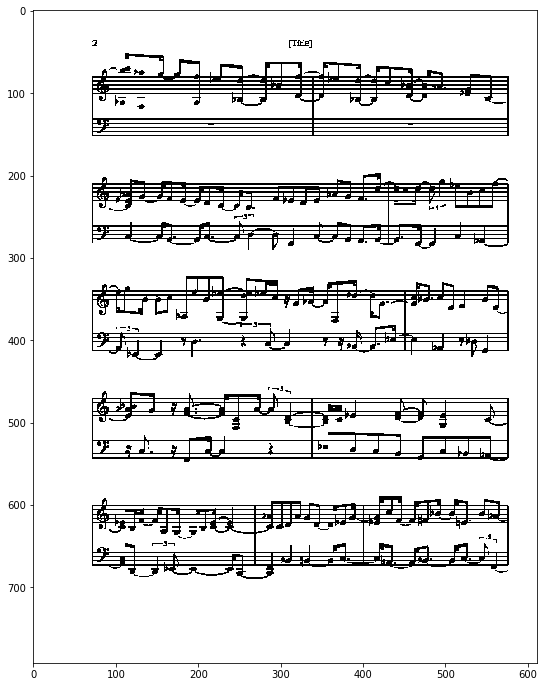

In [6]:
I = importImage(test)
showImage(I)

In [7]:
def rotateToHorizontal(img, lb=-.5, ub=.5, incr=.02, topN=40):
    bestscore = -np.inf
    bestTheta = 0
    for theta in np.arange(lb, ub, incr):
        imgRot = rotate(img,theta)
        rsums = np.sum(imgRot, axis=1)
        rsums_sorted = sorted(rsums)[::-1]
        curscore = np.sum(rsums_sorted[0:topN])
        if curscore > bestscore:
            bestscore = curscore
            bestTheta = theta
    result = rotate(img,bestTheta)
    return result, bestTheta

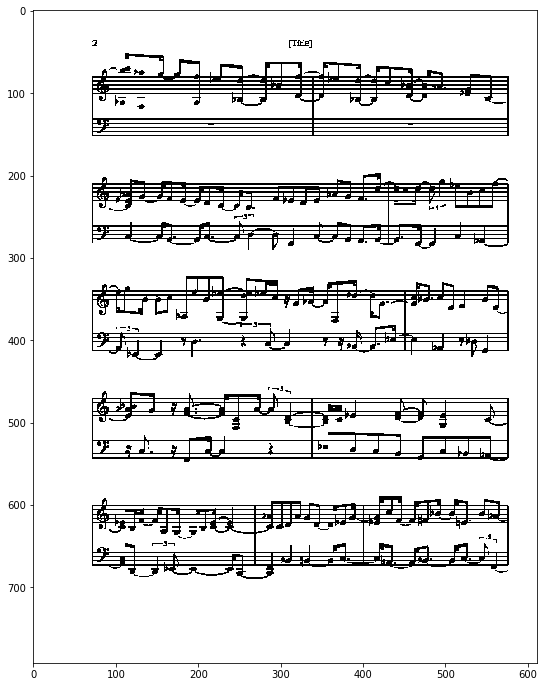

In [8]:
Irot, theta = rotateToHorizontal(I)
showImage(Irot)

In [9]:
def getBoundingBox(img, thresh=.01, buff=0.05):
    r = img.shape[0]
    c = img.shape[1]
    
    cmeans = np.mean(img, axis=0)
    cmean_thresh = np.max(cmeans) * thresh
    cidxs_above = np.argwhere(cmeans > cmean_thresh)
    col_start = cidxs_above[0][0]
    col_end = cidxs_above[-1][0]
    
    rmeans = np.mean(img, axis=1)
    rmean_thresh = np.max(rmeans) * thresh
    ridxs_above = np.argwhere(rmeans > rmean_thresh)
    row_start = ridxs_above[0][0]
    row_end = ridxs_above[-1][0]
    
    # add buffer to ignore clefs
    bufflen = np.int((col_end - col_start) * buff)
    col_start_adj = col_start + bufflen
    
    return (row_start, col_start_adj), col_end - col_start_adj, row_end - row_start

In [12]:
def showImageWithBB(X, loc, w, h, sz=(12,12)):
    fig = plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')
    ax = fig.gca()
    rect = patches.Rectangle((loc[1],loc[0]), w, h, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [10]:
def getCropped(X):
    ll, w, h = getBoundingBox(X)
    return X[ll[0]:ll[0]+h,ll[1]:ll[1]+w]

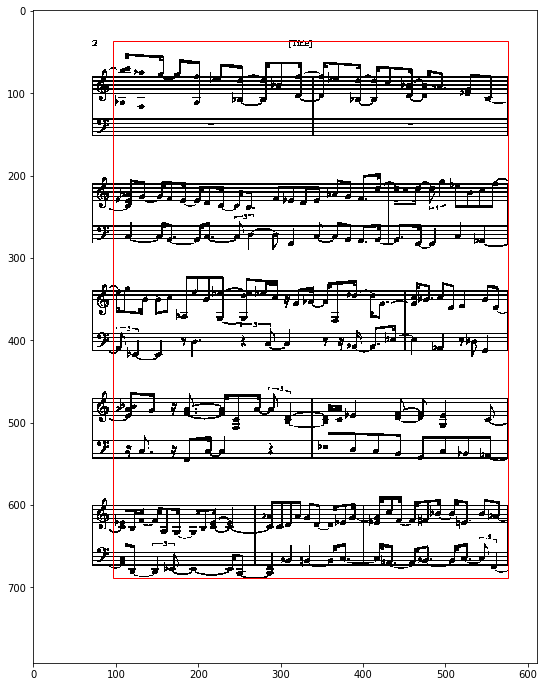

In [13]:
ll, bbw, bbh = getBoundingBox(Irot)
showImageWithBB(Irot, ll, bbw, bbh)

In [30]:
def getStripBoundaries(X, showPlot = False):
    # find staves
    filt = np.vstack((np.ones(21),np.zeros(21),-1*np.ones(21))) # emphasize horizontal lines
    Xfilt = signal.convolve2d(X-np.mean(X), filt, mode='same')
    rsum = np.sum(Xfilt, axis=1)
    rsum_spectra = librosa.core.stft(rsum,n_fft=32,hop_length=1) # look for high frequency oscillations
    spectra_max = np.max(rsum_spectra[4:10,:], axis=0)
    spectra_max_smoothed = np.convolve(spectra_max,np.hanning(15),'same')
    peakidxs = signal.find_peaks_cwt(spectra_max_smoothed, range(15,41,1))
    #assert(len(peakidxs) % 2 == 0)
    
    # determine boundaries
    numStrips = np.int(len(peakidxs))
    boundaries = []
    for i in range(numStrips):
        peak1idx = peakidxs[i]
        if i >= (numStrips - 1):
            break
        peak2idx = peakidxs[i+1]
        midpt = np.int((peak1idx + peak2idx)/2.0)
        boundaries.append(midpt)
    boundaries.insert(0, 0)  # for first strip
    boundaries.append(X.shape[0]-1) # for last strip
    
    # show peak picking results (for debugging)
    if showPlot:
        plt.plot(spectra_max_smoothed)
        for pk in peakidxs:
            plt.axvline(x=pk, color='r', linewidth=1)
            
    return boundaries

In [15]:
def visualizeBoundaries(X, bnds, savefile = None):
    showImage(X)
    for bnd in bnds:
        plt.axhline(y=bnd, color='r', linewidth=1)
    if savefile:
        plt.savefig(savefile)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


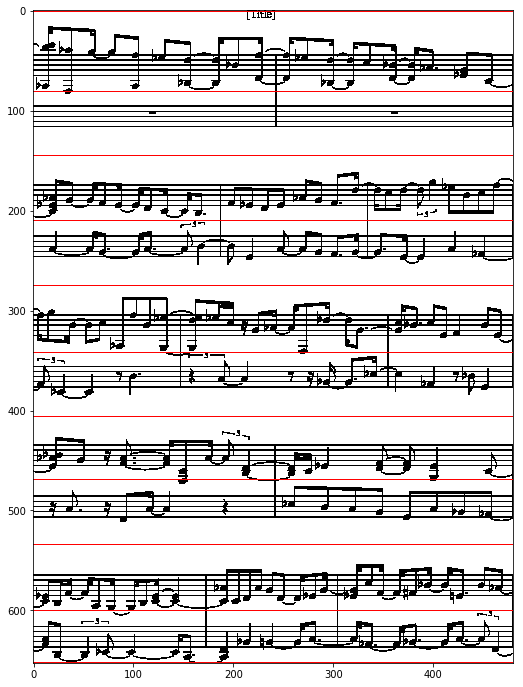

In [31]:
Icrop = getCropped(Irot)
bnds = getStripBoundaries(Icrop)
visualizeBoundaries(Icrop, bnds)

In [17]:
bnds

[0, 144, 274, 405, 534, 652]

Just so I can understand what this is doing: debug version

In [26]:
def showStripBoundaries(X, showPlot = True):
    # find staves
    filt = np.vstack((np.ones(21),np.zeros(21),-1*np.ones(21))) # emphasize horizontal lines
    Xfilt = signal.convolve2d(X-np.mean(X), filt, mode='same')
    plt.imshow(Xfilt)
    plt.show()
    rsum = np.sum(Xfilt, axis=1)
    rsum_spectra = librosa.core.stft(rsum,n_fft=32,hop_length=1) # look for high frequency oscillations
    spectra_max = np.max(rsum_spectra[4:10,:], axis=0)
    spectra_max_smoothed = np.convolve(spectra_max,np.hanning(15),'same')
    peakidxs = signal.find_peaks_cwt(spectra_max_smoothed, range(15,41,1))
    print("peak ids: " + str(peakidxs))
    #assert(len(peakidxs) % 2 == 0)
    
    # determine boundaries
    #numStrips = np.int(len(peakidxs)/2) - 1 # was orignially np.int(len(peakidxs)/2) - 1 but we want all of them
    numStrips = np.int(len(peakidxs))
    print("numstrips: " + str(numStrips))
    boundaries = []
    for i in range(numStrips):
        #peak1idx = peakidxs[2*i + 1]
        peak1idx = peakidxs[i]
        print("peak1idx: " + str(peak1idx))
        if i >= 9:
            break
        #peak2idx = peakidxs[2*i + 2]
        peak2idx = peakidxs[i+1]
        print("peak2idx: " + str(peak2idx))
        midpt = np.int((peak1idx + peak2idx)/2.0)
        print("midpt: " + str(midpt))
        boundaries.append(midpt)
    boundaries.insert(0, 0)  # for first strip
    boundaries.append(X.shape[0]-1) # for last strip
    
    # show peak picking results (for debugging)
    if showPlot:
        plt.plot(spectra_max_smoothed)
        for pk in peakidxs:
            plt.axvline(x=pk, color='r', linewidth=1)
            
    return boundaries

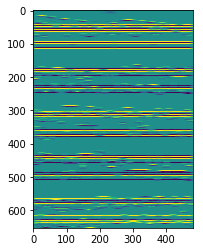

peak ids: [ 53 107 182 236 312 370 440 498 571 629]
numstrips: 10
peak1idx: 53
peak2idx: 107
midpt: 80
peak1idx: 107
peak2idx: 182
midpt: 144
peak1idx: 182
peak2idx: 236
midpt: 209
peak1idx: 236
peak2idx: 312
midpt: 274
peak1idx: 312
peak2idx: 370
midpt: 341
peak1idx: 370
peak2idx: 440
midpt: 405
peak1idx: 440
peak2idx: 498
midpt: 469
peak1idx: 498
peak2idx: 571
midpt: 534
peak1idx: 571
peak2idx: 629
midpt: 600
peak1idx: 629


/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[0, 80, 144, 209, 274, 341, 405, 469, 534, 600, 652]

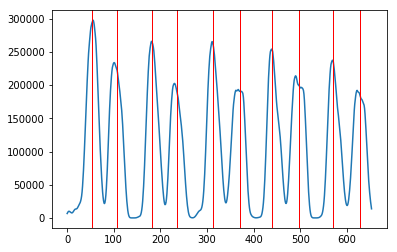

In [27]:
showStripBoundaries(Icrop)

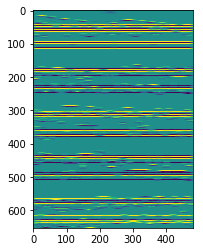

peak ids: [ 53 107 182 236 312 370 440 498 571 629]
numstrips: 10
peak1idx: 53
peak2idx: 107
midpt: 80
peak1idx: 107
peak2idx: 182
midpt: 144
peak1idx: 182
peak2idx: 236
midpt: 209
peak1idx: 236
peak2idx: 312
midpt: 274
peak1idx: 312
peak2idx: 370
midpt: 341
peak1idx: 370
peak2idx: 440
midpt: 405
peak1idx: 440
peak2idx: 498
midpt: 469
peak1idx: 498
peak2idx: 571
midpt: 534
peak1idx: 571
peak2idx: 629
midpt: 600
peak1idx: 629


/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


In [28]:
bounds = showStripBoundaries(Icrop, False)

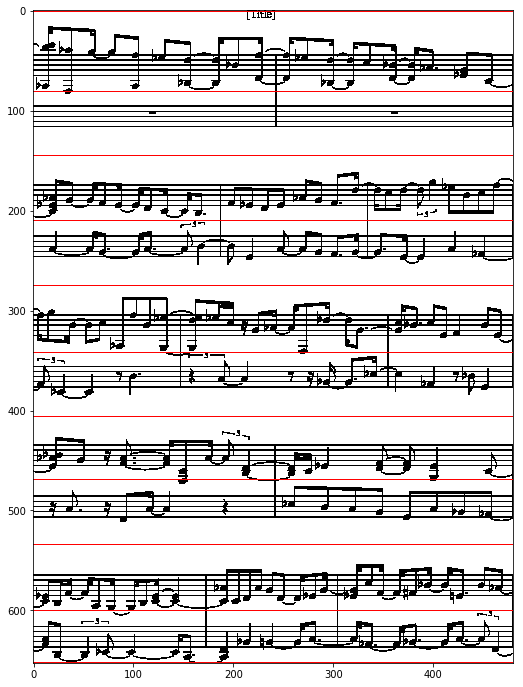

In [29]:
visualizeBoundaries(Icrop, bounds)

It worked!!!

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


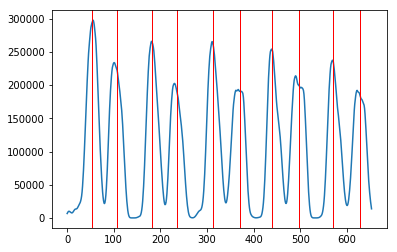

In [33]:
pngfile = test
I = importImage(pngfile)
Irot, theta = rotateToHorizontal(I)
ll, bbw, bbh = getBoundingBox(Irot)
Icrop = getCropped(Irot)
bnds = getStripBoundaries(Icrop, True)
plt.show()

In [34]:
def getStrips(X, bnds):
    strips = []
    for i in range(len(bnds)-1):
        rstart = bnds[i]
        rend = bnds[i+1] + 1 # include endpoint
        chunk = X[rstart:rend,:]
        strips.append(chunk)
    return strips

In [35]:
def showStrips(strips):
    for strip in strips:
        showImage(strip)

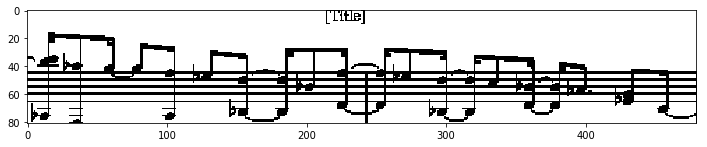

In [36]:
strips = getStrips(Icrop, bnds)
showImage(strips[0])

In [63]:
def locateStaffLinesOld(s, delta = 3, debug=False):
    medvals = np.median(s, axis=1)
    if debug:
        print("num medvals: " + str(len(medvals)))
        print("medvals are: " +  str(medvals))
    for i, curVal in enumerate(medvals):
        if i > delta and i < len(medvals)-delta:
            if curVal != np.max(medvals[i-delta:i+delta+1]): # only keep local maxima
                medvals[i] = 0
    idxs_sorted_val = np.argsort(medvals)[::-1]
    idxs_lines = sorted(idxs_sorted_val[0:10]) # going to change from [0:10] to [0:10] skipping by 2
    if debug:
        print("sorted idxs val before clip: " + str(idxs_sorted_val))
        print("num sorted idxs: " + str(len(idxs_sorted_val)))
        print("idxs_lines number after clip: " + str(len(idxs_lines)))
        print("idxs_lines: " + str(idxs_lines))
    return np.array(idxs_lines)

In [61]:
def locateStaffLines(s, delta = 3, debug=False):
    medvals = np.median(s, axis=1)
    if debug:
        print("num medvals: " + str(len(medvals)))
        print("medvals are: " +  str(medvals))
    for i, curVal in enumerate(medvals):
        if i > delta and i < len(medvals)-delta:
            if curVal != np.max(medvals[i-delta:i+delta+1]): # only keep local maxima
                medvals[i] = 0
    idxs_sorted_val = np.argsort(medvals)[::-1]
    idxs_lines = sorted(idxs_sorted_val[0:10]) # going to change from [0:10] to [0:10] skipping by 2
    idxs_lines = idxs_lines[1::2] # we want just 5, so start at the second and skip every other.
    if debug:
        print("sorted idxs val before clip: " + str(idxs_sorted_val))
        print("num sorted idxs: " + str(len(idxs_sorted_val)))
        print("idxs_lines number after clip: " + str(len(idxs_lines)))
        print("idxs_lines: " + str(idxs_lines))
    return np.array(idxs_lines)

In [38]:
def estimateMidiNum2PixelRowMapping(s, lineIdxs, hand = 'right'):
    if hand == 'right':
        x = np.array([77, 74, 71, 67, 64]) # midi nums for staff lines
    elif hand == 'left':
        x = np.array([57, 53, 50, 47, 43])
    else:
        print('Unrecognized value for hand: %s' % hand)
        sys.exit(1)
    m, b, _, _, _ = linregress(x, lineIdxs)
    return (m,b)

In [40]:
def estimatePixelRow (midinum, m, b):
    return np.int(np.round(midinum * m + b))

In [65]:
s = strips[0]
lines = locateStaffLinesOld(s)
breakpt = np.int(np.round(.5*(lines[4]+lines[5])))
print("lines used to create were: " + str(lines[4]) + " and " + str(lines[5]))
print("breakpoint is : " + str(breakpt))
m, b = estimateMidiNum2PixelRowMapping(s[0:breakpt,:], lines[0:5], 'right')
estC4 = estimatePixelRow(60, m, b)

lines used to create were: 50 and 54
breakpoint is : 52


We'll mess around w the breakpoint.

In [69]:
s = strips[0]
lines = locateStaffLines(s)
breakpt = np.int(np.round(.5*(lines[2]+lines[3])))
m, b = estimateMidiNum2PixelRowMapping(s[0:breakpt,:], lines[0:5], 'right')
estC4 = estimatePixelRow(60, m, b)

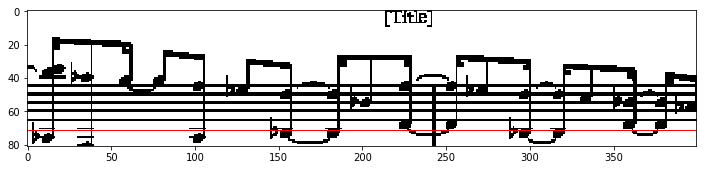

In [70]:
showImage(s[:,0:400])
plt.axhline(y = estC4, color='r', linewidth=1)
plt.show()

In [71]:
estC4

71

Almost perfect

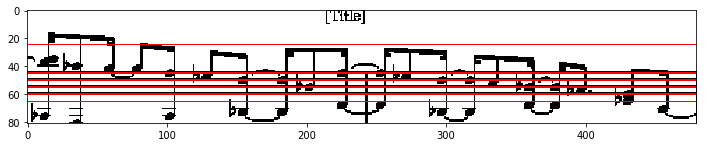

In [45]:
showImage(s)
for line in lines:
    plt.axhline(y = line, color='r', linewidth=1)
plt.show()

Too many lines! Although we ~did~ get all the correct locations...

In [48]:
lines = locateStaffLines(s, debug=True)

num medvals: 81
medvals are: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sorted idxs val before clip: [55 54 59 60 50 44 45 65 49 24 21 22 23 80 20 26 27 28 29 30 31 32 33 25
 18 19 35  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 34 40 36 71
 64 66 67 68 69 70 72 62 73 74 75 76 77 78 63 61 37 46 38 39 79 41 42 43
 47 58 48 51 52 53 56 57  0]
num sorted idxs: 81
idxs_lines number after clip: 10
idxs_lines: [24, 44, 45, 49, 50, 54, 55, 59, 60, 65]


In [72]:
skippedLines = lines[1::2]

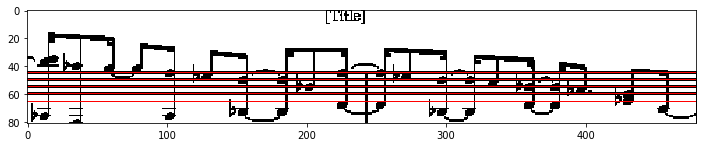

In [60]:
showImage(s)
for line in skippedLines:
    plt.axhline(y = line, color='r', linewidth=1)
plt.show()

# Get Note from Pixel Location

In [73]:
def estimatePixelRow2MidiNumMapping(s, lineIdxs, hand = 'right'):
    if hand == 'right':
        x = np.array([77, 74, 71, 67, 64]) # midi nums for staff lines
    elif hand == 'left':
        x = np.array([57, 53, 50, 47, 43])
    else:
        print('Unrecognized value for hand: %s' % hand)
        sys.exit(1)
    m, b, _, _, _ = linregress(lineIdxs, x)
    return (m,b)

In [78]:
s = strips[0]
lines = locateStaffLines(s)
breakpt = np.int(np.round(.5*(lines[2]+lines[3])))
m, b = estimatePixelRow2MidiNumMapping(s[0:breakpt,:], lines[0:5], 'right')
estNote = estimatePixelRow(40, m, b)

In [79]:
estNote

80

80 is G#/Ab5 which seems about right!

In [80]:
estSixty = estimatePixelRow(60, m, b)

In [81]:
estSixty

67

That is indeed the location of G4.

# Test with another Sheet

We'll use test_non_piano.png

In [82]:
testimg = 'test_non_piano.png'

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


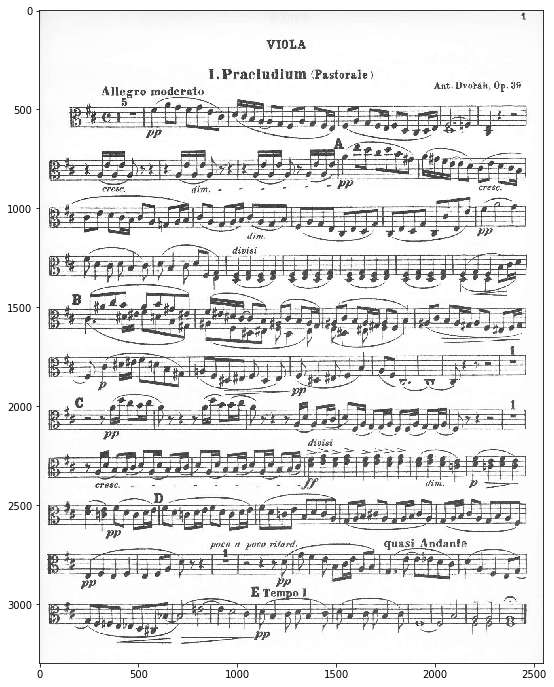

In [83]:
I = importImage(testimg)
showImage(I)

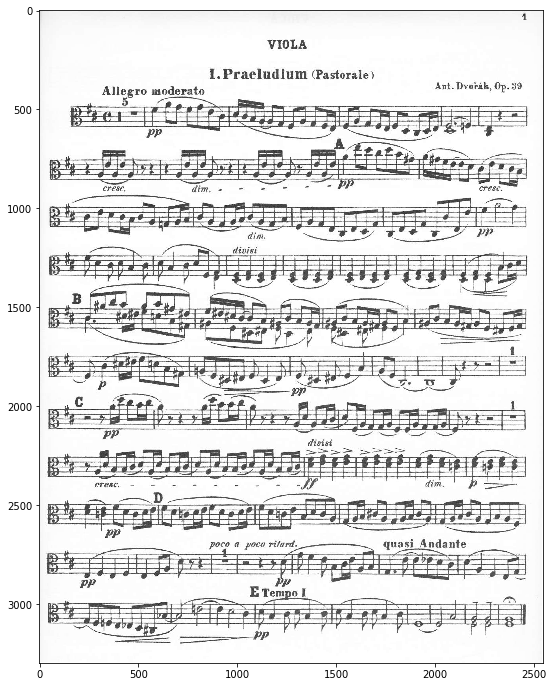

In [84]:
Irot, theta = rotateToHorizontal(I)
showImage(Irot)

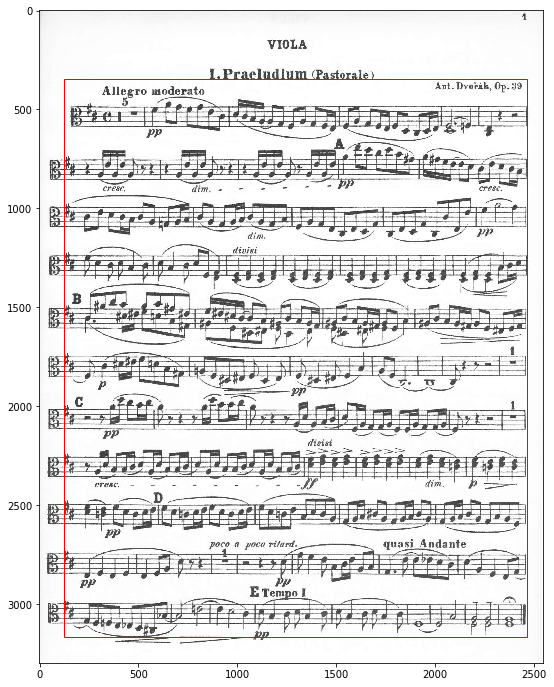

In [110]:
ll, bbw, bbh = getBoundingBox(Irot, thresh=0.22) # so messing around with thresholds appears to work
showImageWithBB(Irot, ll, bbw, bbh)

In [89]:
def getStripBoundariesNonPiano(X, showPlot = False):
    # find staves
    filt = np.vstack((np.ones(21),np.zeros(21),-1*np.ones(21))) # emphasize horizontal lines
    Xfilt = signal.convolve2d(X-np.mean(X), filt, mode='same')
    rsum = np.sum(Xfilt, axis=1)
    rsum_spectra = librosa.core.stft(rsum,n_fft=32,hop_length=1) # look for high frequency oscillations
    spectra_max = np.max(rsum_spectra[4:10,:], axis=0)
    spectra_max_smoothed = np.convolve(spectra_max,np.hanning(15),'same')
    peakidxs = signal.find_peaks_cwt(spectra_max_smoothed, range(15,41,1))
    #assert(len(peakidxs) % 2 == 0)
    
    # determine boundaries
    numStrips = np.int(len(peakidxs)/2) # note the lack of -1 here
    boundaries = []
    for i in range(numStrips):
        peak1idx = peakidxs[2*i]
        peak2idx = peakidxs[2*i+1]
        midpt = np.int((peak1idx + peak2idx)/2.0)
        boundaries.append(midpt)
    boundaries.insert(0, 0)  # for first strip
    boundaries.append(X.shape[0]-1) # for last strip
    
    # show peak picking results (for debugging)
    if showPlot:
        plt.plot(spectra_max_smoothed)
        for pk in peakidxs:
            plt.axvline(x=pk, color='r', linewidth=1)
            
    return boundaries

In [102]:
def getCropped(X, thresh=0.01):
    ll, w, h = getBoundingBox(X, thresh)
    return X[ll[0]:ll[0]+h,ll[1]:ll[1]+w]

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


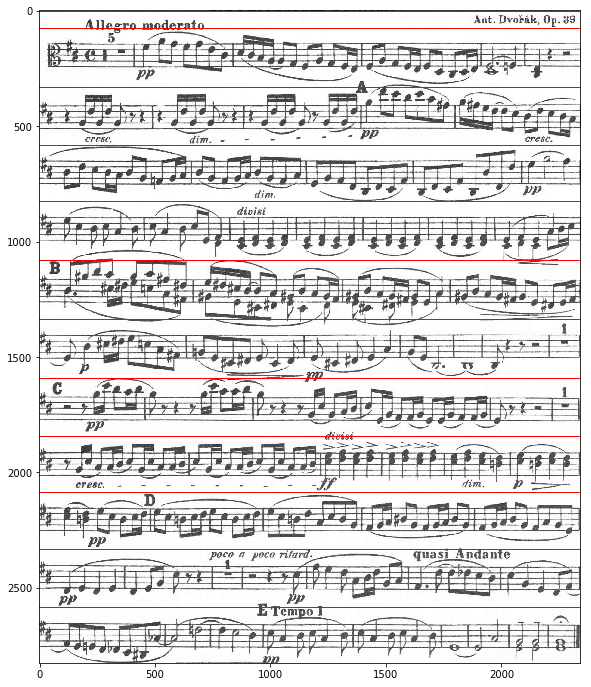

In [103]:
Icrop = getCropped(Irot, thresh=0.2)
bnds = getStripBoundariesNonPiano(Icrop)
visualizeBoundaries(Icrop, bnds)

Let's see what's going on w the bounding box fxn

In [95]:
def getBoundingBoxDebug(img, thresh=.01, buff=0.05, debug=True):
    r = img.shape[0]
    c = img.shape[1]
    if debug:
        print("rows: " + str(r))
        print("cols: " + str(c))
    
    cmeans = np.mean(img, axis=0)
    cmean_thresh = np.max(cmeans) * thresh
    cidxs_above = np.argwhere(cmeans > cmean_thresh)
    col_start = cidxs_above[0][0]
    col_end = cidxs_above[-1][0]
    if debug:
        print("cmeans: " + str(cmeans))
        print("cmean thresh: " + str(cmean_thresh))
        print("col start: " + str(col_start))
        print("col end: " + str(col_end))
    
    rmeans = np.mean(img, axis=1)
    rmean_thresh = np.max(rmeans) * thresh
    ridxs_above = np.argwhere(rmeans > rmean_thresh)
    row_start = ridxs_above[0][0]
    row_end = ridxs_above[-1][0]
    if debug:
        print("rmeans: " + str(rmeans))
        print("rmean thresh: " + str(rmean_thresh))
        print("ridxs above: " + str(ridxs_above))
        print("row start: " + str(row_start))
        print("row end: " + str(row_end))
    
    # add buffer to ignore clefs
    bufflen = np.int((col_end - col_start) * buff)
    col_start_adj = col_start + bufflen
    
    return (row_start, col_start_adj), col_end - col_start_adj, row_end - row_start

In [96]:
ll, bbw, bbh = getBoundingBoxDebug(Irot)

rows: 3298
cols: 2548
cmeans: [0.04106211 0.04507652 0.0484966  ... 0.02034858 0.01785974 0.01543702]
cmean thresh: 0.0018805178399894157
col start: 0
col end: 2547
rmeans: [0.02796897 0.03287684 0.03798354 ... 0.00139441 0.00140056 0.00140628]
rmean thresh: 0.0064015607033827415
ridxs above: [[   0]
 [   1]
 [   2]
 ...
 [3204]
 [3205]
 [3206]]
row start: 0
row end: 3206


So with thresh of .2 it seems fine--just need to ditch first strip.

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


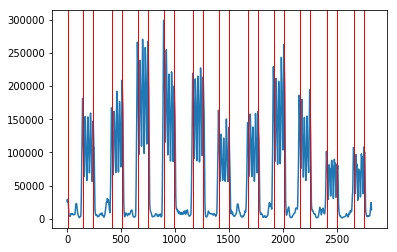

In [115]:
pngfile = testimg
I = importImage(pngfile)
Irot, theta = rotateToHorizontal(I)
ll, bbw, bbh = getBoundingBox(Irot)
Icrop = getCropped(Irot, thresh=0.2)
bnds = getStripBoundariesNonPiano(Icrop, True)
bnds = bnds[1:] # get rid of first
plt.show()

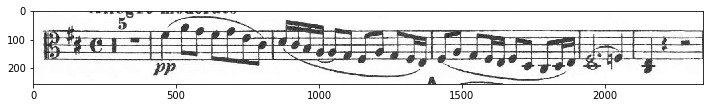

In [116]:
strips = getStrips(Icrop, bnds)
showImage(strips[0])

We're dealing with just one hand here, so we don't really need a breakpoint.

In [127]:
s = strips[0]
lines = locateStaffLines(s)
breakpt = np.int(np.round(.5*(lines[0]+lines[1])))
#m, b = estimateMidiNum2PixelRowMapping(s[0:breakpt,:], lines[0:5], 'right')
m, b = estimateMidiNum2PixelRowMapping(s, lines[0:5], 'right')
estC4 = estimatePixelRow(60, m, b)

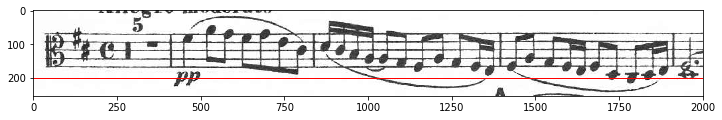

In [128]:
showImage(s[:,0:2000])
plt.axhline(y=estC4, color='r', linewidth=1)
plt.show()

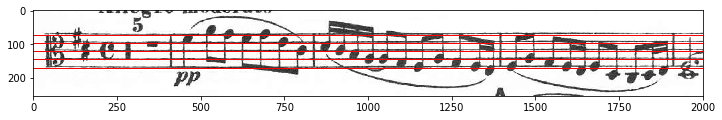

In [129]:
showImage(s[:,0:2000])
for line in lines:
    plt.axhline(y=line, color='r', linewidth=1)
plt.show()

That worked pretty well!

In [130]:
s1 = strips[1]
lines = locateStaffLines(s1)
m1, b1 = estimateMidiNum2PixelRowMapping(s1, lines[0:5], 'right')
estC4 = estimatePixelRow(60, m1, b1)

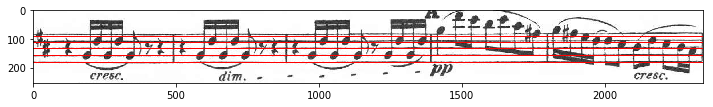

In [131]:
showImage(s1)
for line in lines:
    plt.axhline(y=line, color='r', linewidth=1)
plt.show()

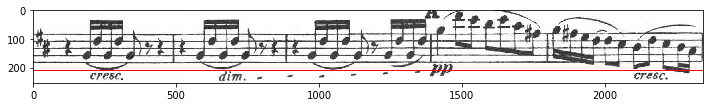

In [132]:
showImage(s1)
plt.axhline(y=estC4, color='r', linewidth=1)
plt.show()

Seems decent (Also note that this is viola music so that isn't technically C4)

In [141]:
s2 = strips[2]
lines = locateStaffLines(s2, delta=1) # messing around w values of delta besides 3
m2, b2 = estimateMidiNum2PixelRowMapping(s2, lines[0:5], 'right')
estC4 = estimatePixelRow(60, m2, b2)

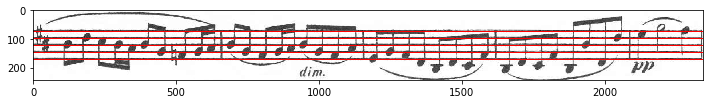

In [142]:
showImage(s2)
for line in lines:
    plt.axhline(y=line, color='r', linewidth=1)
plt.show()

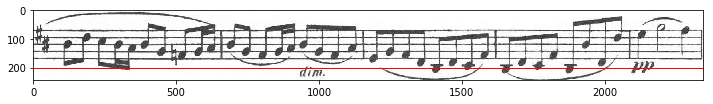

In [143]:
showImage(s2)
plt.axhline(y=estC4, color='r', linewidth=1)
plt.show()

So delta=1 seemed to work better for honing in on the staff lines in this particular case. It didn't seem to help us find "C4", though.

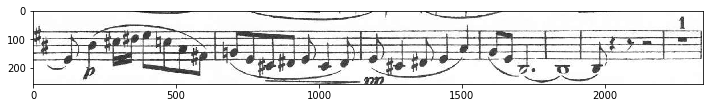

In [145]:
s = strips[5]
showImage(s)

In [156]:
lines = locateStaffLines(s, delta=1)
m, b = estimateMidiNum2PixelRowMapping(s, lines[0:5], 'right')
estC4 = estimatePixelRow(60, m, b)

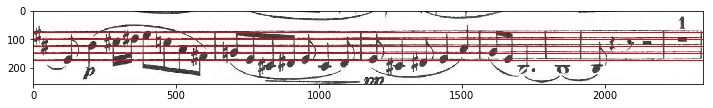

In [157]:
showImage(s)
for line in lines:
    plt.axhline(y=line, color='r', linewidth=1)
plt.show()

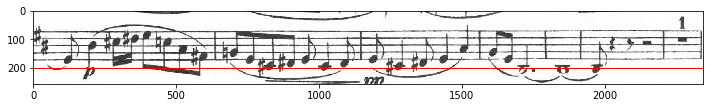

In [151]:
showImage(s)
plt.axhline(y=estC4, color='r', linewidth=1)
plt.show()

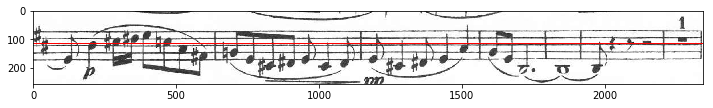

In [158]:
estC5 = estimatePixelRow(72, m, b)
showImage(s)
plt.axhline(y=estC5, color='r', linewidth=1)
plt.show()

C4 is fairly close--C5 is not quite there.

Apply Mek's notehead detector to strips, find center of detected notehead and map it to the line value (MIDI note). Define a separate coordinate system--take middle line and call 0, next line up is 2, then 4, etc. and below is -2.

Make i t so we get a visual of the page with predicted staff line locations superimposed, with bbox predictions from the detector on the page as well. Below that, we want printed tuples with (x,y) where x = x-val on page, y val is the line value we got from the y-location (note value)

Dataset: double of piece: 2 diff scores of the piece (140 scores in mini dataset). That way we can test, if you took pic of same score in database, or if you take pic of same piece but not same score

Hit milestone, look at tons of examples. Make the tool EZ to run. Pres with several examples, show patterns and trends of where it works well and where it is failing. 
Be likw I see 4 types of errors, here's what' sappening and potential solutoins, causes, etc. Pull observations and analysis into a clean and organized presentation.